In [31]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU!")
else:
    print("CUDA is not available. PyTorch will use the CPU.")


CUDA is available. PyTorch can use the GPU!


In [32]:
import os
import pathlib
import pandas as pd
import random


def get_data_df(_parent_data_dir="./data"):
    parent_data_dir = _parent_data_dir
    genres = os.listdir(parent_data_dir)
    data_dirs = [pathlib.Path(parent_data_dir, genre) for genre in genres]
    
    filepath_dict = {}
    for genre in genres:
        filepath_dict[genre] = []
        for root, dir_names, filenames in os.walk(pathlib.Path(parent_data_dir, genre)):
            for name in filenames:
                filepath = pathlib.Path(root, name)
                filepath_dict[genre].append(filepath)
    
    min_files = float("inf")
    for key in filepath_dict.keys():
        files_in_genre = len(filepath_dict[key])
        if files_in_genre < min_files:
            min_files = files_in_genre
    
    random.seed(42)
    genre_dict = {}
    datapoints = []
    for key in filepath_dict.keys():
        genre_dict[key] = random.sample(filepath_dict[key], min_files)
        datapoints += [(key, path) for path in genre_dict[key]]

    genre_df = pd.DataFrame(genres)
    df = pd.DataFrame(datapoints, columns=["genre", "filepath"])
    return df

data = get_data_df()
# print(data_df, labels)

In [33]:
pd.Series(data.loc[:, "genre"]).value_counts()

genre
Folk               8267
Rock               8267
Hip-Hop            8267
Experimental       8267
Chiptune_Glitch    8267
Punk               8267
Electronic         8267
Name: count, dtype: int64

In [34]:
import librosa
import matplotlib.pyplot as plt
import numpy as np


def get_spectrogram(file_path, n_mels=128, duration=10, debug=False):
    samples, sample_rate = librosa.load(file_path, sr=None, duration=duration)
    mel_spectrogram = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=n_mels)  # Maybe we can play with n_mels here.
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to decibels.

    if debug == True:
        # Plot waveform
        plt.figure(figsize=(14, 5))
        librosa.display.waveshow(samples, sr=sample_rate)
        
        # Plot spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(
            librosa.power_to_db(spectrogram, ref=np.max), 
            y_axis='mel', 
            fmax=8000, 
            x_axis='time'
        )
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram')
        plt.tight_layout()

    return mel_spectrogram_db

In [35]:
import pathlib
import numpy as np
import pandas as pd
import time
from concurrent.futures import ProcessPoolExecutor

# This is for grabbing the features. If you've already run this code block,
# You can save the features object in a pickle for future loading.

start_time = time.time()

song_filepaths = data.loc[:, "filepath"]
genres = data.loc[:, "genre"]

def process_file(song_filepath, duration=4):
    spectrogram = get_spectrogram(song_filepath, duration=duration, n_mels=64, debug=False)
    max_val = np.max(np.abs(spectrogram))
    if max_val == 0:
        return None
    else:
        return spectrogram / np.max(np.abs(spectrogram))  # Normalize

features = []
labels = []
for path, genre in zip(song_filepaths, genres):
    feature_set = process_file(path, duration=4)
    if feature_set is None:
        print(f"Not adding silent file: {path}")
    else:
        features.append(feature_set)
        labels.append(genre)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

print("Length of features array: ", len(features))
print("Length of encoded_labels array: ", len(labels))

Not adding silent file: data/Hip-Hop/19511_2.wav
Not adding silent file: data/Hip-Hop/24247_6.wav
Not adding silent file: data/Hip-Hop/24247_2.wav
Not adding silent file: data/Hip-Hop/24247_4.wav
Not adding silent file: data/Hip-Hop/24247_1.wav
Not adding silent file: data/Hip-Hop/3057_0.wav
Not adding silent file: data/Hip-Hop/19511_6.wav
Not adding silent file: data/Experimental/24156_3.wav
Not adding silent file: data/Experimental/24156_2.wav
Not adding silent file: data/Experimental/24156_4.wav
Not adding silent file: data/Experimental/24156_5.wav
Not adding silent file: data/Experimental/24156_0.wav
Not adding silent file: data/Punk/13375_4.wav
Not adding silent file: data/Punk/13375_2.wav
Not adding silent file: data/Punk/13375_5.wav
Not adding silent file: data/Punk/13375_3.wav
Elapsed time: 226.96 seconds
Length of features array:  57853
Length of encoded_labels array:  57853


In [36]:
from sklearn.preprocessing import LabelEncoder

# labels = labels.values.ravel()
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [37]:
reverse_lookup = {}
for feature_set, filepath in zip(features, data.loc[:, "filepath"]):
    reverse_lookup[str(feature_set)] = filepath

print(reverse_lookup[str(features[4])])

data/Folk/1449_1.wav


In [13]:
import pickle

# If you've already run the above block of code and want to save the features variable, run this code block.
features_pickle_path = "features.pkl"
with open(features_pickle_path, 'wb') as file:
        pickle.dump(features, file)

labels_pickle_path = "labels.pkl"
with open(labels_pickle_path, 'wb') as file:
        pickle.dump((labels, label_encoder, encoded_labels), file) 

reverse_lookup_pickle_path = "features_reverse_lookup.pkl"
with open(reverse_lookup_pickle_path, 'wb') as file:
        pickle.dump(reverse_lookup, file) 
    
loaded_features = features
loaded_lookup = reverse_lookup

In [38]:
import pickle

# If you've already run the above block of code and want to save the features variable, run this code block.
features_pickle_path = "features_2.pkl"
with open(features_pickle_path, 'wb') as file:
        pickle.dump(features, file)

labels_pickle_path = "labels_2.pkl"
with open(labels_pickle_path, 'wb') as file:
        pickle.dump((labels, label_encoder, encoded_labels), file) 

reverse_lookup_pickle_path = "features_reverse_lookup_2.pkl"
with open(reverse_lookup_pickle_path, 'wb') as file:
        pickle.dump(reverse_lookup, file) 
    
loaded_features = features
loaded_lookup = reverse_lookup

In [63]:
import pickle

# If you already have saved the features in a pickle, you can use this code to load it back up.

features_pickle_path = "features.pkl"
with open(features_pickle_path, 'rb') as file:
    loaded_features = pickle.load(file)

labels_pickle_path = "labels.pkl"
with open(labels_pickle_path, 'rb') as file:
    labels, label_encoder, encoded_labels = pickle.load(file)
    
reverse_lookup_pickle_path = "features_reverse_lookup.pkl"
with open(reverse_lookup_pickle_path, 'rb') as file:
    loaded_lookup = pickle.load(file)

In [39]:
import pickle

# If you already have saved the features in a pickle, you can use this code to load it back up.

features_pickle_path = "features_2.pkl"
with open(features_pickle_path, 'rb') as file:
    loaded_features = pickle.load(file)

labels_pickle_path = "labels_2.pkl"
with open(labels_pickle_path, 'rb') as file:
    labels, label_encoder, encoded_labels = pickle.load(file)
    
reverse_lookup_pickle_path = "features_reverse_lookup_2.pkl"
with open(reverse_lookup_pickle_path, 'rb') as file:
    loaded_lookup = pickle.load(file)

In [64]:
import numpy as np
# Pad the spectrograms
max_width = max([mel.shape[1] for mel in loaded_features])
        
def pad_spectrogram(mel, max_width):
    pad_width = max_width - mel.shape[1]
    if pad_width > 0:
        print("ping! pad applied! ", loaded_lookup[str(mel)])
    return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')

loaded_features = [pad_spectrogram(mel, max_width) for mel in loaded_features]


ping! pad applied!  data/Punk/9639_2.wav


In [72]:
from torch.utils.data import Dataset
import pathlib


class AudioDataset(Dataset):
    def __init__(self, mel_spectrograms, genre_labels):
        self.mel_spectrograms = mel_spectrograms
        self.labels = genre_labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.mel_spectrograms[idx]
        y = self.labels[idx]

        # Add channel dimension
        x = x.clone().detach().requires_grad_(True).unsqueeze(0)
        y = y.clone().detach().requires_grad_(False)
            
        return x, y

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(loaded_features, encoded_labels, test_size=0.2, random_state=53)

In [43]:
import numpy as np

X_train_array = np.array(X_train)
y_train_array = np.array(y_train)

X_test_array = np.array(X_test)
y_test_array = np.array(y_test)

In [44]:
import torch

# Convert data to PyTorch tensors

X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.long)

# Create PyTorch datasets
train_dataset = AudioDataset(X_train_tensor, y_train_tensor)
test_dataset = AudioDataset(X_test_tensor, y_test_tensor)

# Create PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [45]:
for inputs, labels in train_loader:
    print(inputs.shape)  # Should be (batch_size, 1, 128, int_dependent_upon_length_of_audio_file)
    break

torch.Size([16, 1, 64, 173])


In [46]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(256)



        self.dropout = nn.Dropout(0.5) 
        self.dropout2 = nn.Dropout(0.5) 
        self.dropout3 = nn.Dropout(0.5) 
        self.dropout4 = nn.Dropout(0.5) 
        self.dropout5 = nn.Dropout(0.5) 

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = None  # Placeholder for dynamic initialization
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, num_classes)


    def forward(self, x):
        # Pass through conv and pool layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Shape: (batch_size, 32, height/2, width/2)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Shape: (batch_size, 64, height/4, width/4)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Shape: (batch_size, 128, height/8, width/8)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Shape: (batch_size, 128, height/8, width/8)
        x = self.pool(F.relu(self.bn5(self.conv5(x))))  # Shape: (batch_size, 128, height/8, width/8)
        x = self.pool(F.relu(self.bn6(self.conv6(x))))  # Shape: (batch_size, 128, height/8, width/8)

        # Dynamically initialize fc1 based on input size
        if self.fc1 is None:
            flattened_size = x.view(x.size(0), -1).size(1)  # Calculate flattened size
            self.fc1 = nn.Linear(flattened_size, 128).to(x.device)

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.dropout4(x)
        x = self.fc5(x)
        x = self.dropout5(x)
        x = self.fc6(x)
        return x


In [49]:
import torch.optim as optim
import time
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
num_classes = len(label_encoder.classes_)
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.5)

base_start_time = time.time()

model.to(device)  # Move the model to the GPU/CPU

# Training loop
num_epochs = 64
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)  # Move inputs to GPU/CPU
        labels = labels.to(device)  # Move labels to GPU/CPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    learning_rate = scheduler.get_last_lr()
    scheduler.step()
    print("--" * 20)
    print(f"Epoch {epoch+1}, Learning rate: {learning_rate}")
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Epoch {epoch+1}, Elapsed Time: {elapsed_time:.2f} seconds")


print("--" * 30)
print("--" * 30)
# Evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Move inputs to GPU/CPU
        labels = labels.to(device)  # Move labels to GPU/CPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")
base_end_time = time.time()
base_elapsed_time = base_end_time - base_start_time
print(f"Total Elapsed Time: {base_elapsed_time:.2f} seconds")
print("--" * 30)
print("--" * 30)

----------------------------------------
Epoch 1, Learning rate: [0.001]
Epoch 1, Loss: 1.5685122040700137
Epoch 1, Elapsed Time: 22.75 seconds
----------------------------------------
Epoch 2, Learning rate: [0.001]
Epoch 2, Loss: 1.3075526742386314
Epoch 2, Elapsed Time: 22.81 seconds
----------------------------------------
Epoch 3, Learning rate: [0.001]
Epoch 3, Loss: 1.2043232713403316
Epoch 3, Elapsed Time: 22.82 seconds
----------------------------------------
Epoch 4, Learning rate: [0.001]
Epoch 4, Loss: 1.134727186710415
Epoch 4, Elapsed Time: 22.82 seconds
----------------------------------------
Epoch 5, Learning rate: [0.0005]
Epoch 5, Loss: 1.0342634900029126
Epoch 5, Elapsed Time: 22.83 seconds
----------------------------------------
Epoch 6, Learning rate: [0.0005]
Epoch 6, Loss: 0.9907504291197358
Epoch 6, Elapsed Time: 22.92 seconds
----------------------------------------
Epoch 7, Learning rate: [0.0005]
Epoch 7, Loss: 0.955989014358616
Epoch 7, Elapsed Time: 22.91

Confusion Matrix:
[[1231  272   69   15   24    5   29]
 [ 223  984  178   44  138   27   83]
 [  65  134 1125  113   35   21  118]
 [   4   21  107 1409   15   14  135]
 [  21  175   51   23 1345   20   21]
 [   7   32   65   37   24  961  504]
 [  24   68  140  135   30  387  863]]


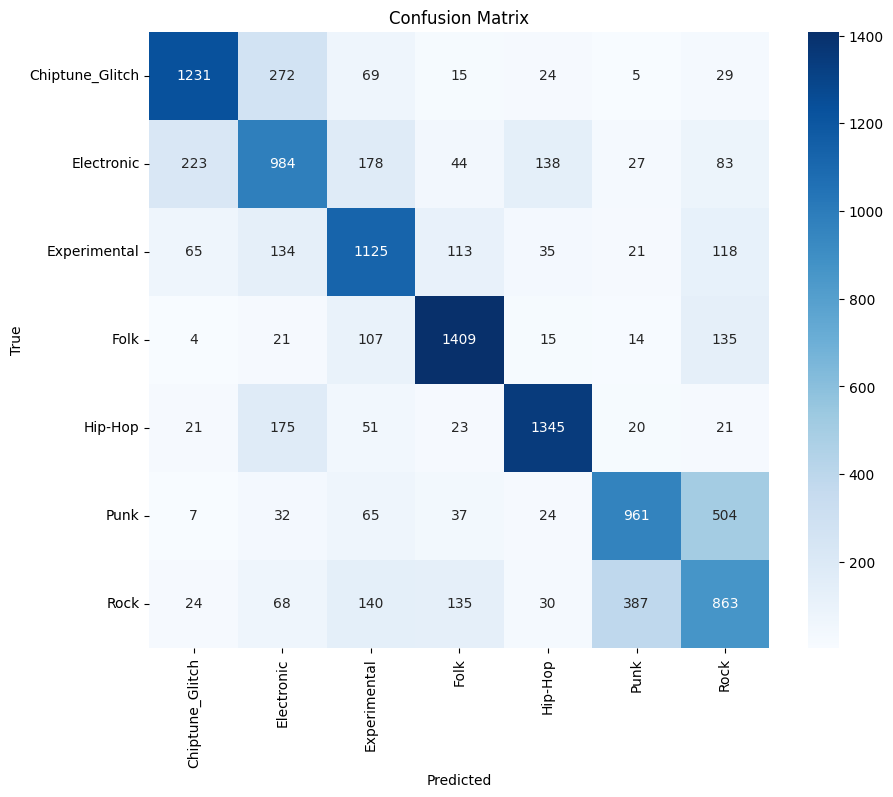

Classification Report:
                 precision    recall  f1-score   support

Chiptune_Glitch       0.78      0.75      0.76      1645
     Electronic       0.58      0.59      0.59      1677
   Experimental       0.65      0.70      0.67      1611
           Folk       0.79      0.83      0.81      1705
        Hip-Hop       0.83      0.81      0.82      1656
           Punk       0.67      0.59      0.63      1630
           Rock       0.49      0.52      0.51      1647

       accuracy                           0.68     11571
      macro avg       0.69      0.68      0.68     11571
   weighted avg       0.69      0.68      0.68     11571



In [50]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_preds = []
all_labels = []

# Switch model to evaluation mode
model.eval()
model.to(device)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Move inputs to GPU if available
        labels = labels.to(device)  # Move labels to GPU if available
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get class predictions
        all_preds.extend(preds.cpu().numpy())  # Convert predictions to NumPy
        all_labels.extend(labels.cpu().numpy())  # Convert labels to NumPy

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# Add class names to the confusion matrix.
class_names = label_encoder.classes_
plot_confusion_matrix(cm, class_names)

# Print a classification report.
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)


In [53]:
import torch

model_path = "68_pct_model.pt"
torch.save(model, model_path)

In [79]:
model_path = "68_pct_model.pt"
model = torch.load(model_path)
model.eval()

print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

/tmp/ipykernel_91984/3382508148.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [96]:
model_path = "68_pct_model.pt"
model = torch.load(model_path)
model.eval()

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# fc6
if hasattr(model, 'fc6'):
    model.fc6 = nn.Identity()

import numpy as np

features_array = np.array(loaded_features)
labels_array = np.array(encoded_labels)

features_tensor = torch.tensor(features_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)

clustering_dataset = AudioDataset(features_tensor, labels_tensor)
clustering_dataloader = torch.utils.data.DataLoader(clustering_dataset, batch_size=32, shuffle=False)

clustering_features = []

with torch.no_grad():
    for inputs, labels in train_loader:
        # print(inputs)
        model = model.to(device)
        inputs = inputs.to(device)

        outputs = model(inputs)
        clustering_features.append(outputs.cpu().numpy())

clustering_features = np.concatenate(clustering_features, axis=0)


/tmp/ipykernel_91984/874273514.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


In [97]:
for feat in clustering_features:
    print(feat.shape)  # Should be (128,)

(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)

In [98]:
from sklearn.cluster import KMeans


n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(clustering_features)
labels = kmeans.labels_

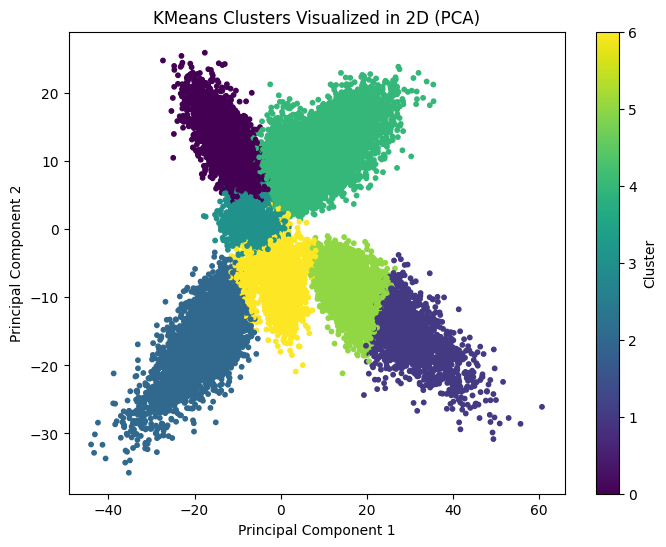

In [99]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(clustering_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans.labels_, cmap='viridis', s=10)
plt.colorbar(label='Cluster')
plt.title("KMeans Clusters Visualized in 2D (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [92]:
print(labels)

[3 3 3 ... 3 1 4]
